In this notebook several implementations of the discretized 1D model (Jarrah's) with diffusion are implemented, every one with a different kind of boundary conditions. The following portion of code is common to all implementations.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd

#damage function
def damage(t, sigma, m, h):

    if t==0 or t <=1e-15:       ######## Elena, ricontrollati i limiti dei float in Python
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

#diffusion functions
def diff_H(i, dx, D_H, H):
    
    if i==0:
        tmp1 = H[i+1] - H[i]
        if tmp1<1e-7:
            #print(0)
            return 0
        else:
            #print(tmp1)
            #print(D_H / dx * tmp1)
            return D_H / dx * tmp1
    elif i==len(H)-1:
        tmp2 = H[i-1] - H[i]
        if tmp2<1e-7:
            #print(0)
            return 0
        else:
            #print(tmp2)

            #print(D_H / dx * tmp2)
            return D_H / dx * tmp2
    else:
        tmp1 = H[i+1] - H[i]
        tmp2 = H[i-1] - H[i]
        if tmp1<1e-7 and tmp2<1e-7:
            #print(0)
            return 0
        else:
            #print(tmp1+tmp2)
            #print(D_H / dx * (tmp1 + tmp2))
            return D_H / dx * (tmp1 + tmp2)

def diff_C(i, dx, D_C, C):
    
    if i==0:
        tmp1 = C[i+1] - C[i]
        if tmp1<1e-7:
            #print("Zero", end=f"\nC[{i+1}] = ")
            #print(C[i+1], end=f"\nC[{i}] = ")
            #print(C[i], end="\n\n")
            return 0
        else:
            #print("Non zero", end=f"\nC[{i+1}] = ")
            #print(tmp1, end="\n   ")
            #print(C[i+1], end=f"\nC[{i}] = ")

            #print(C[i], end="\n\n")
            return D_C / dx * tmp1
    elif i==len(C)-1:
        tmp2 = C[i-1] - C[i]
        if tmp2<1e-7:
            #print("Zero", end=f"\nC[{i-1}] = ")
            #print(C[i-1], end=f"\nC[{i}] = ")
            #print(C[i], end="\n\n")
            return 0
        else:
            #print("Non zero", end=f"\nC[{i-1}] = ")
            #print(tmp2, end="   ")
            #print(C[i-1], end=f"\nC[{i}] = ")
            #print(C[i], end="\n\n")
            return D_C / dx * tmp2
    else:
        tmp1 = C[i+1] - C[i]
        tmp2 = C[i-1] - C[i]
        if tmp1<1e-7 and tmp2<1e-7:
            #print("Zero", end=f"\nC[{i+1}] = ")
            #print(C[i+1], end=f"\nC[{i-1}] = ")
            #print(C[i-1], end=f"\nC[{i}] = ")

            #print(C[i], end="\n\n")
            return 0
        else:
            #print("Non zero", end=f"\nC[{i+1}] = ")
            #print(tmp1+tmp2, end="   ")
            #print(C[i+1], end=f"\nC[{i-1}] = ")
            #print(C[i-1], end=f"\nC[{i}] = ")
            #print(C[i], end="\n\n")
            return D_C / dx * (tmp1 + tmp2)

def diff_M(i, dx, D_M, M):

    if i==0:
        tmp1 = M[i+1] - M[i]
        if tmp1<1e-7:
            #print(0)
            return 0
        else:
            #print(tmp1)
            #print(D_M / dx * tmp1)
            return D_M / dx * tmp1
    elif i==len(M)-1:
        tmp2 = M[i-1] - M[i]
        if tmp2<1e-7:
            #print(0)

            return 0
        else:
            #print(tmp2)
            #print(D_M / dx * tmp2)
            return D_M / dx * tmp2
    else:
        tmp1 = M[i+1] - M[i]
        tmp2 = M[i-1] - M[i]
        if tmp1<1e-7 and tmp2<1e-7:
            #print(0)
            return 0
        else:
            #print(tmp1+tmp2)
            #print(D_M / dx * (tmp1 + tmp2))
            return D_M / dx * (tmp1 + tmp2)
            

In the following version edge cells are initialized as the other ones and both immune cells and muscle tissue evolve following the same law as the other cells.

4817298048


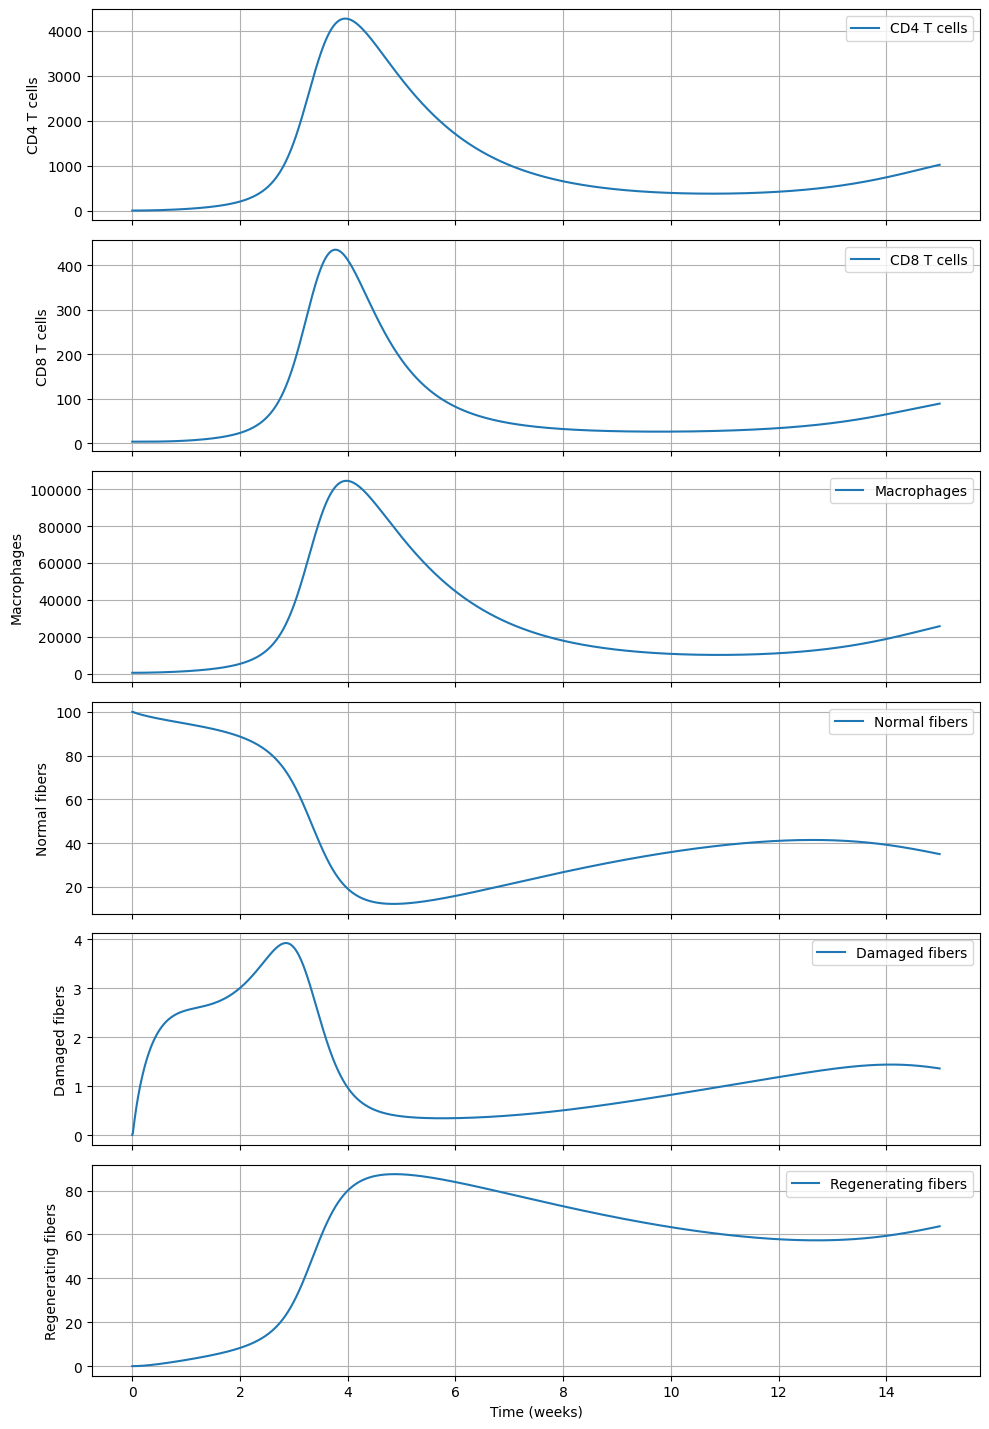

In [39]:
def one_step(N_cells, t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, initial_conditions, parameters, diff_coeff):

    H_i, C_i, M_i, N_i, D_i, R_i = initial_conditions
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = parameters
    D_H, D_C, D_M = diff_coeff

    for i in range(N_cells):
        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

#evolution immune cells
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new):
    H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))
#in case you want a specific precision use (e.g. 7 digits):
#H_new[i] = float("{:.7f}".format(H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))))

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new):
    C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i - C[i]))

def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new):
    M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i - M[i]))
    
#evolution composition muscle tissue
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
    
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])
    

##################################################################################################################################
##################################################simulation######################################################################
##################################################################################################################################

#create an instance of the ConfigParser class
config = configparser.ConfigParser()
#read the contents of the `config.ini` file
#this file stores the values of parameters used in the simulation
config.read('config.ini')

#initial conditions
initial_conditions = []
if 'initial_conditions' in config:
    for key, value in config['initial_conditions'].items():
        initial_conditions.append(float(value))
else:
    print('Section \'initial_conditions\' is not in the configuration file')

#parameters
parameters = []
if 'parameters' in config:
    for key, value in config['parameters'].items():
        parameters.append(float(value))
else:
    print('Section \'parameters\' is not in the configuration file')    

#diffusion coefficients
diff_coeff = []
if 'diff_coeff' in config:
    for key, value in config['diff_coeff'].items():
        diff_coeff.append(float(value))
else:
    print('Section \'diff_coeff\' is not in the configuration file')

#simulation choices
sim = []
if 'simulation_par' in config:
    for key, value in config['simulation_par'].items():
        sim.append(float(value))
else:
    print('Section \'simulation_par\' is not in the configuration file')
dt, t_min, t_max, dx, N_cells = sim
N_cells = int(N_cells)

#create the array to store the temporal steps at which the evolution is computed
t = [t_min]

#create a list of N_cells values for each state variable and one to perform the temporal evolution
H = [initial_conditions[0]] * (N_cells)
C = [initial_conditions[1]] * (N_cells)
M = [initial_conditions[2]] * (N_cells)
N = [initial_conditions[3]] * (N_cells)
D = [initial_conditions[4]] * (N_cells)
R = [initial_conditions[5]] * (N_cells)

H_new = [initial_conditions[0]] * (N_cells)
C_new = [initial_conditions[1]] * (N_cells)
M_new = [initial_conditions[2]] * (N_cells)
N_new = [initial_conditions[3]] * (N_cells)
D_new = [initial_conditions[4]] * (N_cells)
R_new = [initial_conditions[5]] * (N_cells)

#these lists will store the values of each state variable in every cell;
#NB: I cannot just assign H_values = H because later in the code I modify H
H_values = [H.copy()]
C_values = [C.copy()]
M_values = [M.copy()]
N_values = [N.copy()]
D_values = [D.copy()]
R_values = [R.copy()]

#evolution over time
for j in range(0, int((t_max-t_min)/dt)):

    one_step(N_cells, t[j], dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, initial_conditions, parameters, diff_coeff)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()   
    
    H_values.append(H_new.copy())
    C_values.append(C_new.copy())
    M_values.append(M_new.copy())
    N_values.append(N_new.copy())
    D_values.append(D_new.copy())
    R_values.append(R_new.copy())
    t.append(j / (1/dt))    ###not the best way to write it, but somehow with multiplication it messes up (I've no idea why)

#Here's something else I find kind of mysterious: if I print *_values some of the lists printed
#are no more list of float, but I get something like [np.float64(...some_number...), ...]; in order to avoid
#problems, the following line converts all type to float
H_converted = [[float(value) for value in sublist] for sublist in H_values]
C_converted = [[float(value) for value in sublist] for sublist in C_values]
M_converted = [[float(value) for value in sublist] for sublist in M_values]
N_converted = [[float(value) for value in sublist] for sublist in N_values]
D_converted = [[float(value) for value in sublist] for sublist in D_values]
R_converted = [[float(value) for value in sublist] for sublist in R_values]

#columns_H = [[row[i] for row in H_converted] for i in range(len(H_converted[0]))]
#columns_C = [[row[i] for row in C_converted] for i in range(len(C_converted[0]))]
#columns_M = [[row[i] for row in M_converted] for i in range(len(M_converted[0]))]
#columns_N = [[row[i] for row in N_converted] for i in range(len(N_converted[0]))]
#columns_D = [[row[i] for row in D_converted] for i in range(len(D_converted[0]))]
#columns_R = [[row[i] for row in R_converted] for i in range(len(R_converted[0]))]

#use list comprehensions to extract the first column (which correspond to the evolution the first cell)
column_H_0 = [row[2] for row in H_converted]
column_C_0 = [row[2] for row in C_converted]
column_M_0 = [row[2] for row in M_converted]
column_N_0 = [row[2] for row in N_converted]
column_D_0 = [row[2] for row in D_converted]
column_R_0 = [row[2] for row in R_converted]

first_cell = [column_H_0, column_C_0, column_M_0, column_N_0, column_D_0, column_R_0]

#we plot the evolution in the first cell; since all cells are initialized in the same way
#this is representative of the evolution in all cells
n_vars = len(initial_conditions)
labels = ["CD4 T cells", "CD8 T cells", "Macrophages", "Normal fibers", "Damaged fibers", "Regenerating fibers"]

#create subplots
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t, first_cell[i], label=labels[i])
    axes[i].set_ylabel(labels[i])
    axes[i].legend()
    axes[i].grid(True)

#the last subplot is the only one with the label on the x axes
axes[-1].set_xlabel('Time (weeks)')

#adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.show()    

In the following version edge cells are initialized with the same initial conditions as the other ones, but cannot evolve. Both the concentration of immune cells and the percentage of different muscle tissues remain fixed.

4840612352


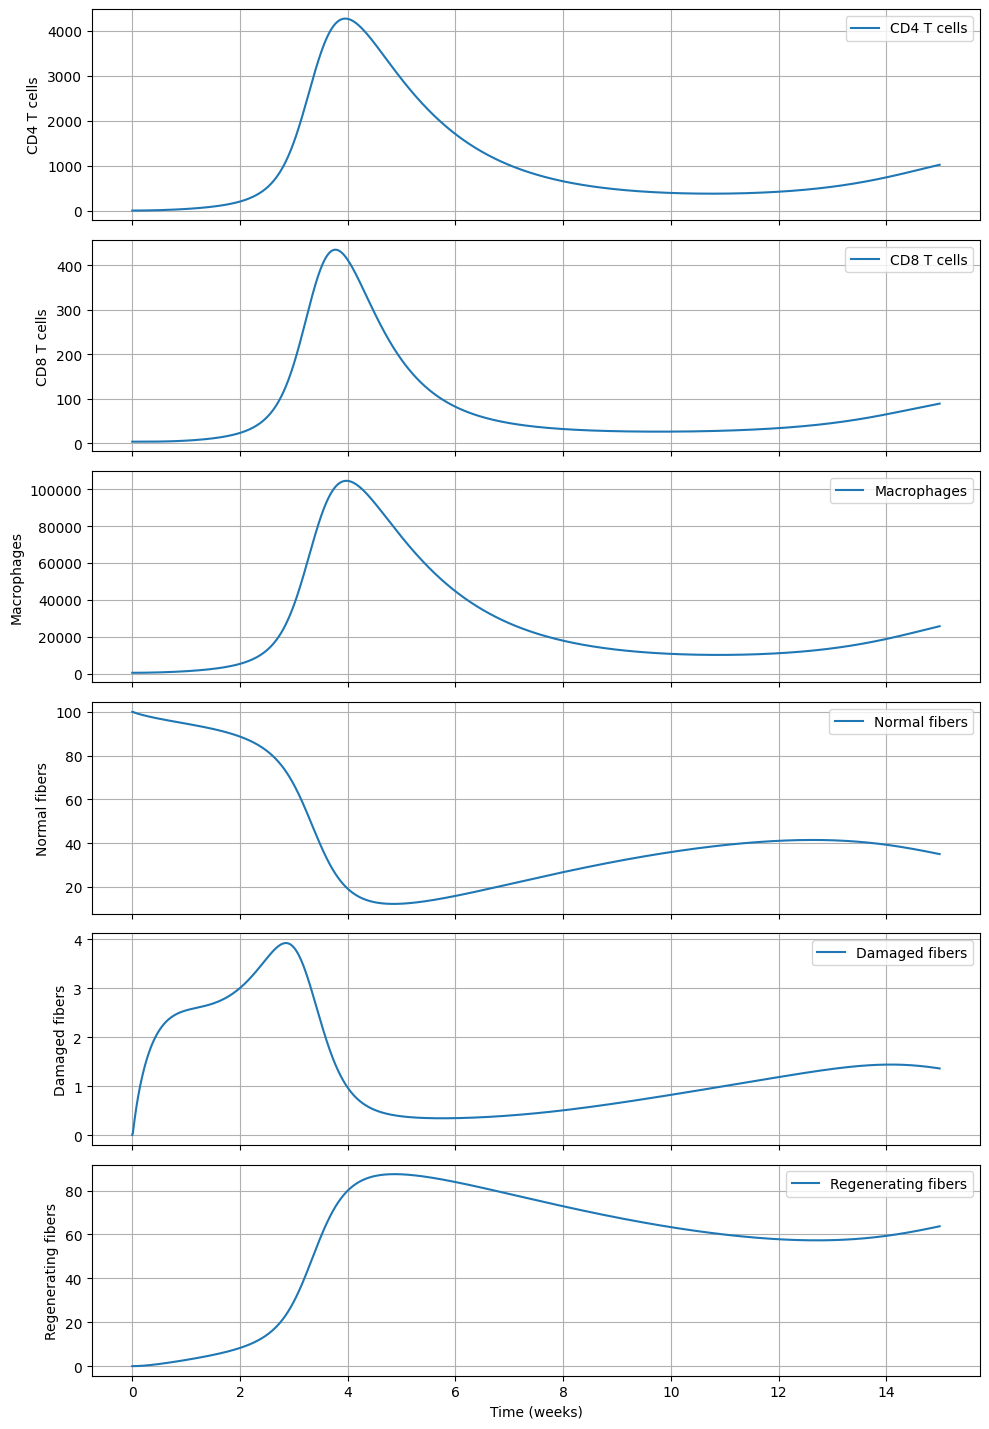

In [40]:
def one_step(N_cells, t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, initial_conditions, parameters, diff_coeff):

    H_i, C_i, M_i, N_i, D_i, R_i = initial_conditions
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = parameters
    D_H, D_C, D_M = diff_coeff

    for i in range(N_cells):
        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

#evolution immune cells
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new):
    if i==0 or i==N_cells-1:
        H_new[i] = H[i]
    else:
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new):
    if i==0 or i==N_cells-1:
        C_new[i] == C[i]
    else:
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i - C[i]))

def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new):
    if i==0 or i==N_cells-1:
        M_new[i] == M[i]
    else:
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i - M[i]))
    
#evolution composition muscle tissue
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    if i==0 or i==N_cells-1:
        N_new[i] = N[i]
    else:

        N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    if i==0 or i==N_cells-1:
        D_new[i] = D[i]
    else:
        D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
    
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    if i==0 or i==N_cells-1:
        R_new[i] = R[i]
    else:
        R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])


##################################################################################################################################
##################################################simulation######################################################################
##################################################################################################################################

#create an instance of the ConfigParser class
config = configparser.ConfigParser()
#read the contents of the `config.ini` file
#this file stores the values of parameters used in the simulation
config.read('config.ini')

#initial conditions
initial_conditions = []
if 'initial_conditions' in config:
    for key, value in config['initial_conditions'].items():
        initial_conditions.append(float(value))
else:
    print('Section \'initial_conditions\' is not in the configuration file')

#parameters
parameters = []
if 'parameters' in config:
    for key, value in config['parameters'].items():
        parameters.append(float(value))
else:
    print('Section \'parameters\' is not in the configuration file')    

#diffusion coefficients
diff_coeff = []
if 'diff_coeff' in config:
    for key, value in config['diff_coeff'].items():
        diff_coeff.append(float(value))
else:
    print('Section \'diff_coeff\' is not in the configuration file')

#simulation choices
sim = []
if 'simulation_par' in config:
    for key, value in config['simulation_par'].items():
        sim.append(float(value))
else:
    print('Section \'simulation_par\' is not in the configuration file')
dt, t_min, t_max, dx, N_cells = sim
N_cells = int(N_cells)

#create the array to store the temporal steps at which the evolution is computed
t = [t_min]

#create a list of N_cells values for each state variable and one to perform the temporal evolution
H = [initial_conditions[0]] * (N_cells)
C = [initial_conditions[1]] * (N_cells)
M = [initial_conditions[2]] * (N_cells)
N = [initial_conditions[3]] * (N_cells)
D = [initial_conditions[4]] * (N_cells)
R = [initial_conditions[5]] * (N_cells)

H_new = [initial_conditions[0]] * (N_cells)
C_new = [initial_conditions[1]] * (N_cells)
M_new = [initial_conditions[2]] * (N_cells)
N_new = [initial_conditions[3]] * (N_cells)
D_new = [initial_conditions[4]] * (N_cells)
R_new = [initial_conditions[5]] * (N_cells)

#these lists will store the values of each state variable in every cell;
#NB: I cannot just assign H_values = H because later in the code I modify H
H_values = [H.copy()]
C_values = [C.copy()]
M_values = [M.copy()]
N_values = [N.copy()]
D_values = [D.copy()]
R_values = [R.copy()]

#evolution over time
for j in range(0, int((t_max-t_min)/dt)):

    one_step(N_cells, t[j], dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, initial_conditions, parameters, diff_coeff)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()   
    
    H_values.append(H_new.copy())
    C_values.append(C_new.copy())
    M_values.append(M_new.copy())
    N_values.append(N_new.copy())
    D_values.append(D_new.copy())
    R_values.append(R_new.copy())
    t.append(j / (1/dt))    ###not the best way to write it, but somehow with multiplication it messes up (I've no idea why)

#Here's something else I find kind of mysterious: if I print *_values some of the lists printed
#are no more list of float, but I get something like [np.float64(...some_number...), ...]; in order to avoid
#problems, the following line converts all type to float
H_converted = [[float(value) for value in sublist] for sublist in H_values]
C_converted = [[float(value) for value in sublist] for sublist in C_values]
M_converted = [[float(value) for value in sublist] for sublist in M_values]
N_converted = [[float(value) for value in sublist] for sublist in N_values]
D_converted = [[float(value) for value in sublist] for sublist in D_values]
R_converted = [[float(value) for value in sublist] for sublist in R_values]

#print(C_converted)

#columns_H = [[row[i] for row in H_converted] for i in range(len(H_converted[0]))]
#columns_C = [[row[i] for row in C_converted] for i in range(len(C_converted[0]))]
#columns_M = [[row[i] for row in M_converted] for i in range(len(M_converted[0]))]
#columns_N = [[row[i] for row in N_converted] for i in range(len(N_converted[0]))]
#columns_D = [[row[i] for row in D_converted] for i in range(len(D_converted[0]))]
#columns_R = [[row[i] for row in R_converted] for i in range(len(R_converted[0]))]

#use list comprehensions to extract the first column (which correspond to the evolution the first cell)
column_H_0 = [row[2] for row in H_converted]
column_C_0 = [row[2] for row in C_converted]
column_M_0 = [row[2] for row in M_converted]
column_N_0 = [row[2] for row in N_converted]
column_D_0 = [row[2] for row in D_converted]
column_R_0 = [row[2] for row in R_converted]

first_cell = [column_H_0, column_C_0, column_M_0, column_N_0, column_D_0, column_R_0]

#we plot the evolution in the first cell; since all cells are initialized in the same way
#this is representative of the evolution in all cells
n_vars = len(initial_conditions)
labels = ["CD4 T cells", "CD8 T cells", "Macrophages", "Normal fibers", "Damaged fibers", "Regenerating fibers"]

#create subplots
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t, first_cell[i], label=labels[i])
    axes[i].set_ylabel(labels[i])
    axes[i].legend()
    axes[i].grid(True)

#the last subplot is the only one with the label on the x axes
axes[-1].set_xlabel('Time (weeks)')

#adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.show()    